# Forecasting Long-Term Stock Returns

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/FinanceOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmlHaWuVxIA0pKL1yjryR0Z)

## Introduction

We study the predictive relationship between the P/Sales ratio and the annualized return of the S&P 500 stock-market index and some individual stocks. For shorter investment periods, the P/Sales ratio is found to be a weak predictor for the stock's return, but for longer periods of 10 years, the P/Sales ratio is a strong predictor for the return of the S&P 500 and some individual stocks.

This is a very important discovery and it has implications for many areas of both theoretical and applied finance. It means that the U.S. stock-market as a whole is not "efficient" and does not follow a purely "random walk" in the long-term. It is possible to estimate the future long-term return of the stock-market and some individual stocks from just a single indicator variable.

The core idea comes from the author's research-book from the year 2015: [Strategies for Investing in the S&P 500](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2653676). Hidden deep inside that book in Section 13.1.4 on page 84, the following formula is found for predicting the 10-year annualized return of the S&P 500:

$$
Annualized\ Return \simeq 23.4\% – 4.9\% \cdot P/Book
$$

In this work we will primarily use the P/Sales ratio as the predictor variable instead, because the historical P/Sales ratio may be easier to obtain for some companies, and because the P/Book ratio is more sensitive to changes in capitalization structure for individual companies.

These results open a whole new branch of important research in corporate and investment finance. Hopefully both students and experienced researchers will see the value of this knowledge and greatly extend the study presented below.

## Python Imports

This Jupyter Notebook is implemented in Python v. 3.6 and requires various packages for numerical computations and plotting. See the installation instructions in the README-file.

In [1]:
%matplotlib inline

In [2]:
# Imports from Python packages.
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import os

In [3]:
# Imports from FinanceOps.
from curve_fit import CurveFitLinear, CurveFitReciprocal
from data_keys import *
from data import load_index_data, load_stock_data, load_usa_cpi
from returns import annualized_returns, prepare_ann_returns

## Load Data

We now load all the financial data we will be using.

In [4]:
# Define the ticker-names for the stocks we consider.
ticker_SP500 = "S&P 500"
ticker_JNJ = "JNJ"
ticker_K = "K"
ticker_PG = "PG"
ticker_WMT = "WMT"

In [5]:
# Load the financial data for the stocks.
df_SP500 = load_index_data(ticker=ticker_SP500)
df_JNJ = load_stock_data(ticker=ticker_JNJ)
df_K = load_stock_data(ticker=ticker_K)
df_PG = load_stock_data(ticker=ticker_PG)
df_WMT = load_stock_data(ticker=ticker_WMT)

In [6]:
# Load the US CPI inflation index.
cpi = load_usa_cpi()

## Plotting Functions

These are helper-functions used for making plots.

In [7]:
def normalize(x):
    """Normalize x to be between 0.0 and 1.0"""
    y = (x - x.min())
    y /= y.max()
    
    return y

In [8]:
def plot_total_return_sales_book_value(df, ticker):
    """
    Plot the Total Return, Sales Per Share, and
    Book-Value Per Share in one plot.
    The data is normalized to be between 0 and 1.

    :param df: Pandas DataFrame with PSALES and TOTAL_RETURN.
    :param ticker: Name for the stock or index.
    :return: Nothing.
    """

    # Copy the relevant data.
    df2 = df[[SALES_PER_SHARE,
              BOOK_VALUE_PER_SHARE,
              TOTAL_RETURN]].copy()

    # Drop all rows with NA.
    df2.dropna(axis=0, how='any', inplace=True)

    # Normalize the data to be between 0 and 1.
    df2[TOTAL_RETURN] = normalize(df2[TOTAL_RETURN])
    df2[SALES_PER_SHARE] = normalize(df2[SALES_PER_SHARE])
    df2[BOOK_VALUE_PER_SHARE] = normalize(df2[BOOK_VALUE_PER_SHARE])

    # Plot it.
    df2.plot(title=ticker)

In [9]:
def plot_scatter_fit(ax, years, ticker, x, y, x_name):
    """
    Create a scatter-plot with curve-fits.
    
    :param ax: Matplotlib ax-object.
    :param years: Number of years for annualized returns.
    :param ticker: Ticker-name for the stock or index.
    :param x: Data for the x-axis e.g. P/Sales values.
    :param y: Data for the y-axis e.g. annualized returns.
    :return: Nothing.
    """
    # Scatter-plot of the data.
    ax.scatter(x, y)

    # First part of the title.
    title1 = "[{0}] {1}-Year Ann. Return".format(ticker, years)

    # X-values for plotting fitted curves.
    x_min = np.min(x)
    x_max = np.max(x)
    
    # Plot linear curve-fit.
    curve_fit_linear = CurveFitLinear(x=x, y=y)
    x_range = np.array([x_min, x_max])
    y_pred = curve_fit_linear.predict(x=x_range)
    ax.plot(x_range, y_pred, color='black')
    # Title with these curve-fit parameters.
    title2 = "black = {0:.1%} x " + x_name + " + {1:.1%}"
    title2 = title2.format(*curve_fit_linear.params)

    # Plot reciprocal curve-fit.
    curve_fit_reciprocal = CurveFitReciprocal(x=x, y=y)
    x_range = np.arange(x_min, x_max, (x_max/x_min)/1000)
    y_pred = curve_fit_reciprocal.predict(x=x_range)
    ax.plot(x_range, y_pred, color='red')
    # Title with these curve-fit parameters.
    title3 = "red = {0:.1%} / " + x_name + " + {1:.1%}"
    title3 = title3.format(*curve_fit_reciprocal.params)

    # Combine and set the plot-title.
    title = "\n".join([title1, title2, title3])
    ax.set_title(title)

    # Convert y-ticks to percentages.
    # We use a custom FuncFormatter because PercentFormatter
    # is inconsistent with string-formatters used elsewhere.
    formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
    ax.yaxis.set_major_formatter(formatter)

In [10]:
def plot_ann_returns(ticker, df, key=PSALES):
    """
    Create multiple scatter-plots with P/Sales or P/Book
    vs. Annualized Returns for 1-10 years.
    
    :param ticker: Ticker-name for the stock or index.
    :param df: Pandas DataFrame containing PSALES and TOTAL_RETURN.
    :param key: Name of data-column to use, PSALES or PBOOK.
    :return: Nothing.
    """

    # Create 10 sub-plots.
    fig, axes = plt.subplots(5, 2, figsize=(10, 20))
    fig.subplots_adjust(hspace=0.6, wspace=0.15)

    # For each sub-plot make a new scatter-plot.
    for i, ax in enumerate(axes.flat):
        # The number of years for the annualized returns.
        years = i + 1

        # Prepare the data.
        # x is the P/Sales or P/Book and y is the annualized returns.
        x, y = prepare_ann_returns(df=df, years=years, key=key)

        # Scatter-plot with curve-fits etc.
        plot_scatter_fit(ax=ax, years=years, x_name=key,
                         ticker=ticker, x=x, y=y)
        
        # Set the x-label.
        ax.set_xlabel(key)

        # Only set y-label for left-hand plots to save space.
        if i % 2 == 0:
            ax.set_ylabel("Annualized Return")
            
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [11]:
def plot_ann_returns_adjusted(ticker, df, years, subtract, key=PSALES):
    """
    Create a single scatter-plot with P/Sales or P/Book
    vs. Annualized Returns for the given number of years.
    The returns are growth-adjusted with the subtract-series.
    
    This is used for plotting the P/Sales vs. Ann. Returns of
    e.g. the S&P 500 adjusted for the growth in Sales-Per-Share
    or the growth in the Consumer Price Index.
    
    :param ticker: Ticker-name for the stock or index.
    :param df: Pandas DataFrame containing PSALES and TOTAL_RETURN.
    :param key: Name of data-column to use, PSALES or PBOOK.
    :param years: Number of years for annualized returns.
    :param subtract: Pandas Series used for growth-adjustment.
    :return: Nothing.
    """

    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Prepare the data.
    # x is the P/Sales or P/Book.
    # y is the adjusted annualized returns.
    x, y = prepare_ann_returns(df=df, years=years,
                               subtract=subtract, key=key)
    
    # Scatter-plot with curve-fits etc.
    plot_scatter_fit(ax=ax, years=years, x_name=key,
                     ticker=ticker, x=x, y=y)

    # Set the axis-labels.
    ax.set_xlabel(key)
    ax.set_ylabel("Annualized Return (Growth Adjusted)")
   
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [12]:
def plot_total_return(df, ticker, start_date=None):
    """
    Plot the Total Return.

    :param df: Pandas DataFrame with TOTAL_RETURN.
    :param ticker: Ticker-name for the stock or index.
    :param start_date: Start-date for the plot.
    :return: Nothing.
    """

    # Get the data from the given start-date.
    tot_ret = df[TOTAL_RETURN][start_date:].dropna()
    
    # Normalize to start at 1.
    tot_ret /= tot_ret[0]
    
    # Plot it.
    tot_ret.plot(title=ticker + " - Total Return", grid=True)

In [13]:
def plot_psales(df, ticker, start_date=None):
    """
    Plot the P/Sales ratio.

    :param df: Pandas DataFrame with PSALES.
    :param ticker: Ticker-name for the stock or index.
    :param start_date: Start-date for the plot.
    :return: Nothing.
    """

    psales = df[PSALES][start_date:].dropna()
    psales.plot(title=ticker + " - P/Sales", grid=True)

In [14]:
def plot_pbook(df, ticker, start_date=None):
    """
    Plot the P/Book ratio.

    :param df: Pandas DataFrame with PBOOK.
    :param ticker: Ticker-name for the stock or index.
    :param start_date: Start-date for the plot.
    :return: Nothing.
    """

    psales = df[PBOOK][start_date:].dropna()
    psales.plot(title=ticker + " - P/Book", grid=True)

## S&P 500

The S&P 500 is a stock-market index consisting of the stocks of 500 of the largest companies in USA. The S&P 500 covers about 80% of the whole U.S. stock-market in terms of size so it is useful as a gauge for the entire U.S. stock-market.

We consider the Total Return of the S&P 500 which is what you would get from investing in the S&P 500 and re-investing all dividends back into the S&P 500.

Let us first plot the Total Return for the period we consider:

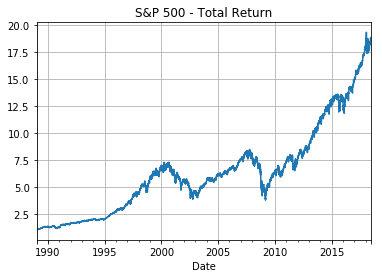

In [15]:
# Only use the Total Return for the period
# where we have P/Sales data as well.
start_date = df_SP500[PSALES].dropna().index[0]
plot_total_return(df=df_SP500, ticker=ticker_SP500,
                  start_date=start_date)

We want to use the P/Sales ratio for predicting the long-term Total Return of the S&P 500. The P/Sales ratio is defined as the price-per-share divided by the sales-per-share for the past 12 months.

Let us plot the P/Sales ratio for this period:

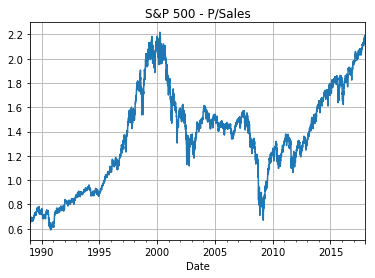

In [16]:
plot_psales(df=df_SP500, ticker=ticker_SP500, start_date=start_date)

We can also plot the P/Book ratio for this period:

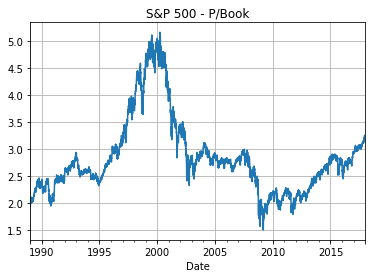

In [17]:
plot_pbook(df=df_SP500, ticker=ticker_SP500, start_date=start_date)

### S&P 500 - P/Sales vs. Annualized Returns

The following scatter-plots show the P/Sales ratio versus the Annualized Returns of the S&P 500 for periods from 1 to 10 years.

For example, the last plot is for 10-year investment periods. So to produce this plot, for each date we first calculate the Total Return of the S&P 500 over the next 10 years, then we calculate the Annualized Return from that, and then we put a blue dot in the scatter-plot for that date's P/Sales ratio and the Annualized Return we just calculated. This process is continued for all dates in the time-series, until we have calculated and plotted the P/Sales vs. Annualized Return for all 10-year investment periods.

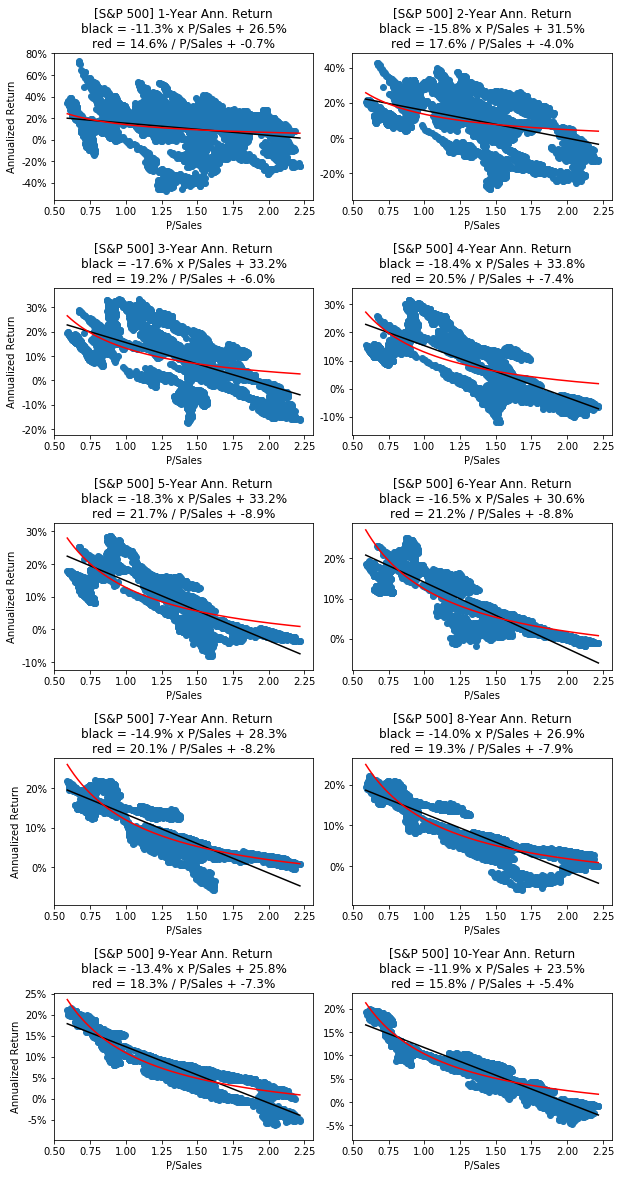

In [18]:
plot_ann_returns(ticker=ticker_SP500, df=df_SP500, key=PSALES)

As can be seen from these scatter-plots, the P/Sales ratio is a weak predictor for shorter investment periods but a strong predictor for longer investment periods.

The first plot shows 1-year investment periods and has a large "blob" of blue dots with poorly fitted return-curves. This means the P/Sales ratio is a weak predictor for the 1-year returns of the S&P 500.

This makes sense because in the short-term the P/Sales ratio only changes because of the share-price as the sales-per-share is almost constant in the short-term. And it seems highly unlikely that we can predict future returns from the share-price alone.

The last plot shows 10-year investment periods where the curves fit the blue dots quite well, so the P/Sales ratio is a strong predictor for 10-year returns of the S&P 500.

In the following, we will sometimes refer to these fitted curves as "Return Curves".

### S&P 500 - P/Book vs. Annualized Returns

We can make similar scatter-plots using the P/Book ratio instead of the P/Sales ratio as the predictor variable. For the S&P 500 the plots look quite similar, although the fitted "return curves" have different parameters.

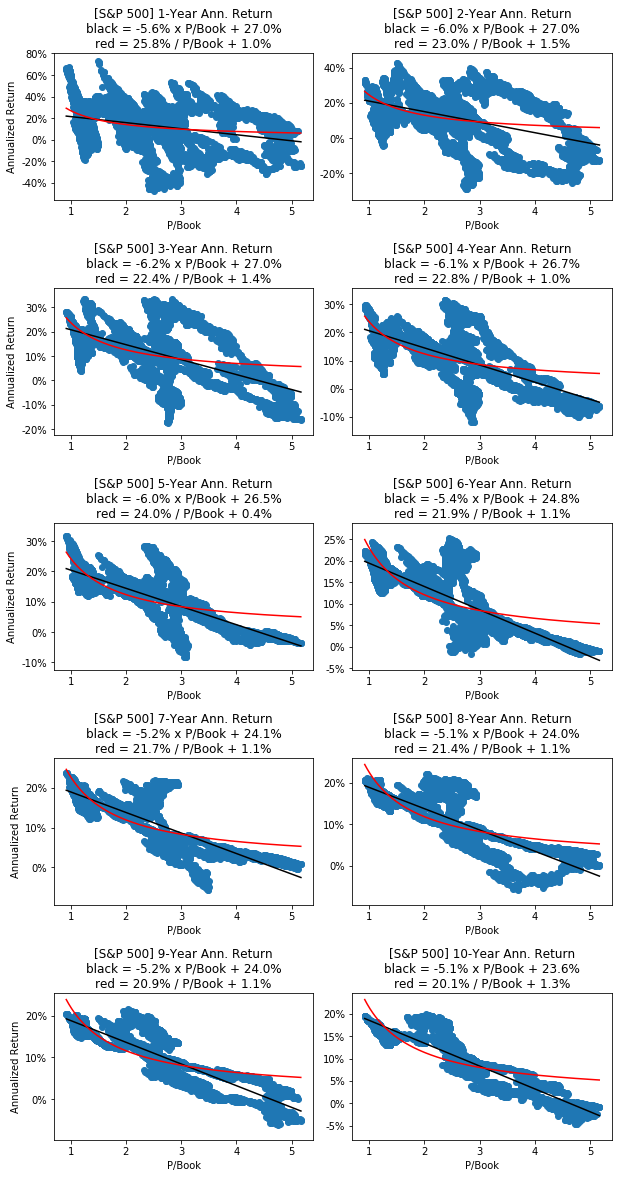

In [19]:
plot_ann_returns(ticker=ticker_SP500, df=df_SP500, key=PBOOK)

### S&P 500 - Forecasting Next 10-Year Return using P/Sales

Towards the end of 2017, the P/Sales ratio was about 2.2 for the S&P 500. We can forecast the 10-year annualized returns using the fitted "return curves" and formulas from the plots above. If you purchased the S&P 500 in December 2017 and will keep the investment until the end of 2027 while reinvesting all dividends during those 10 years (all taxes are ignored), then the formula forecasts this return:

$$
Annualized\ Return = -11.9\% \cdot P/Sales + 23.5\% = -11.9\% \cdot 2.2 + 23.5\% \simeq -2.7\%
$$

This means that you would lose an estimated -2.7% per year on your investment in the S&P 500 between December 2017 and December 2027, according to this formula.

Let us plot a histogram of the historical P/Sales data where we can also see that the P/Sales ratio of 2.2 is at the very top, so the S&P 500 was indeed priced historically high in December 2017 according to this metric.

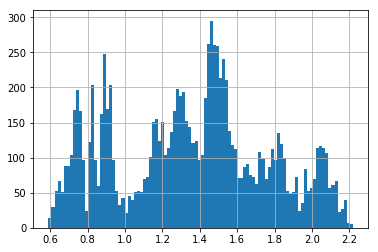

In [20]:
df_SP500[PSALES].hist(bins=100, grid=True)

Also look at the plot further above of the historical P/Sales ratio, which shows that the last time the P/Sales ratio was so high for the S&P 500 was around year 2000, which was at the peak of the so-called "Dot-Com Bubble" that was followed by a big market-crash.

However, one thing that is different in 2017 compared to the Dot-Com Bubble in 2000, is that the technology companies that were fairly small back in year 2000 have now become some of the largest companies in the world. Furthermore, these large tech companies often have very high profit margins, so the average profit margin of the S&P 500 is now about 9% compared to only about 7% around year 2000, so perhaps a slightly higher P/Sales ratio is justified in the future. (Data Source: [S&P 500 Earnings & Estimates](http://www.spindices.com/documents/additional-material/sp-500-eps-est.xlsx))

### S&P 500 - Forecasting Next 10-Year Return using P/Book

We can also use the formula with the P/Book ratio instead. Towards the end of 2017 the P/Book ratio was about 3.2 for the S&P 500. The formula then gives the forecasted return:

$$
Annualized\ Return = -5.1\% \cdot P/Book + 23.6\% = -5.1\% \cdot 3.2 + 23.5\% \simeq 7.2\%
$$

This is much different than the forecasted annual loss of -2.7% when using the formula with the P/Sales ratio instead. It is unclear why the two formulas give such different forecasts. Maybe it is related to higher profit-margins and debt-to-equity ratios, but a deeper investigation of the financial data would be needed to uncover a plausible reason.

We can also show a histogram of the historical P/Book ratios for the S&P 500, where the P/Book value of 3.2 can be seen to be at the start of the distributions' higher end.

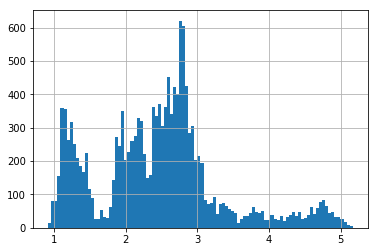

In [21]:
df_SP500[PBOOK].hist(bins=100, grid=True)

### S&P 500 - Adjusting for Sales-Growth

Although the above forecasting formulas using the P/Sales and P/Book ratios disagree on the future returns, there is still a clear trend in the data shown in the many scatter-plots above, which suggests the long-term return of the S&P 500 is strongly related to the purchase price relative to the Sales Per Share or Book-Value Per Share.

These results go directly against long-held beliefs in finance that it is impossible to predict the future return of the stock-market. One objection to these formulas might be that we did not take into account the growth in Sales Per Share and this could maybe affect these trends and predictions.

Let us first plot the Sales Per Share for the S&P 500 which has grown significantly but slightly irregularly during this period:

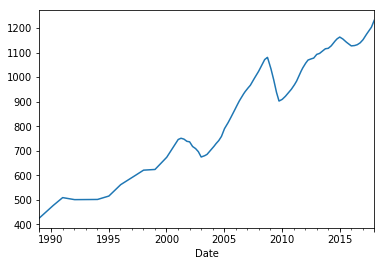

In [22]:
df_SP500[SALES_PER_SHARE].dropna().plot()

We can now make the same scatter-plots as above but adjusted for the growth in Sales Per Share. We only plot this for 10-year periods which had the strongest predictive relationship. The new scatter-plot looks almost identical and the fitted lines have almost the same parameters as above.

This shows that the strong relationship between the P/Sales ratio and the future 10-year returns of the S&P 500 persists even when adjusting for the future sales-growth.

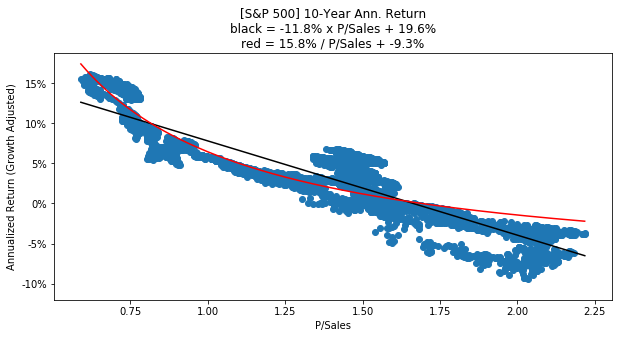

In [23]:
plot_ann_returns_adjusted(df=df_SP500, years=10, ticker=ticker_SP500,
                          subtract=df_SP500[SALES_PER_SHARE])

### S&P 500 - Adjusting for Inflation

Similarly, you might object that the predictive relationship did not take inflation into account. We can therefore adjust the annualized returns of the S&P 500 by subtracting the inflation, as measured by the growth in the U.S. Consumer Price Index (CPI).

First we plot the CPI for the same period as the S&P 500 data, which shows the CPI rose steadily during this period:

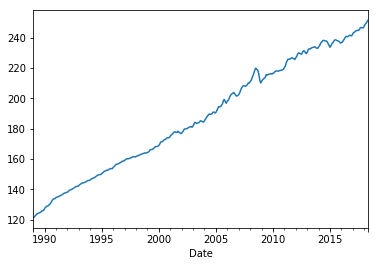

In [24]:
start_date = df_SP500[SALES_PER_SHARE].dropna().index[0]
cpi[start_date:].plot()

Once again we make a scatter-plot of the P/Sales versus the adjusted annualized returns for all 10-year periods of the S&P 500. The plot and curve-fittings look almost identical to the original scatter-plot above. We might have expected this because the CPI grew very steadily during this period, so it could not have a major influence on the adjusted annualized returns.

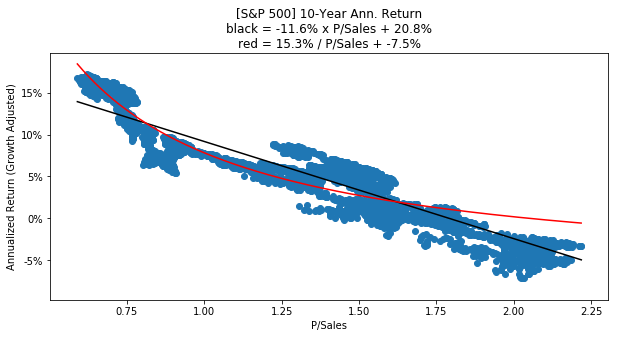

In [25]:
plot_ann_returns_adjusted(df=df_SP500, years=10,
                          ticker=ticker_SP500, subtract=cpi)

## Case Study: Johnson & Johnson (JNJ)

Now let us consider individual companies instead of a whole stock-market index. The first company we consider is Johnson & Johnson with the ticker symbol JNJ. This is a very large company with over 130.000 employees worldwide that manufacture a wide range of health-care related products.

When we plot the P/Sales ratio versus the annualized return, we see that the reciprocal return curve fits very well even for shorter investment periods.

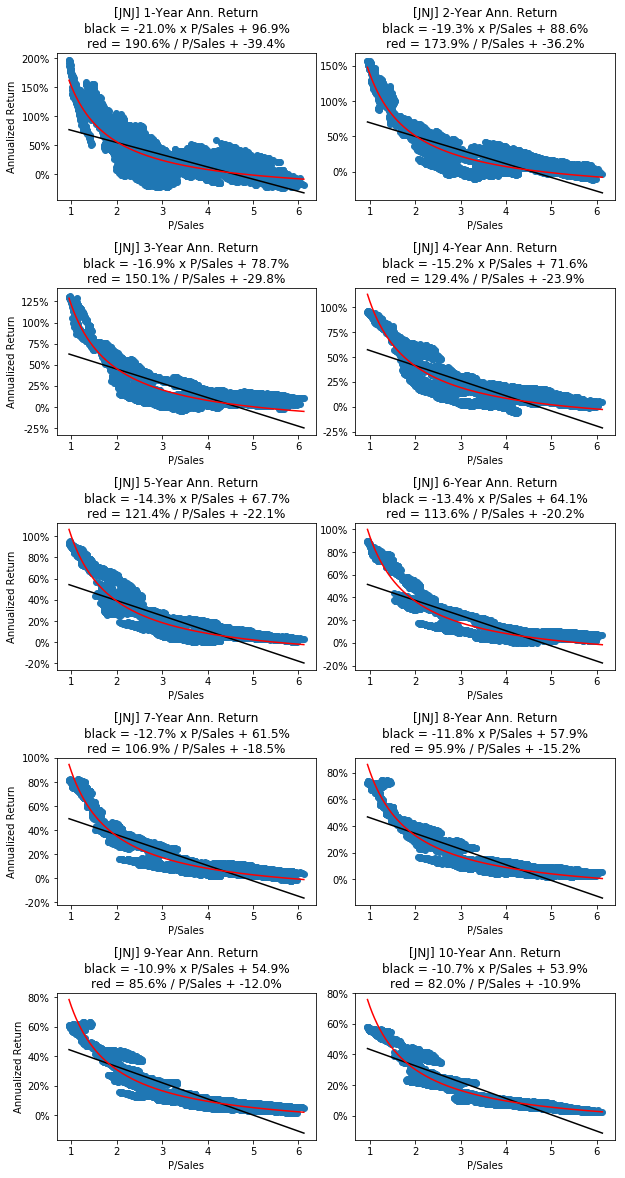

In [26]:
plot_ann_returns(ticker=ticker_JNJ, df=df_JNJ, key=PSALES)

Towards the end of 2017 the P/Sales ratio was about 4.9 which is close to the all-time historical highs experienced during the stock-market bubble around year 2000.

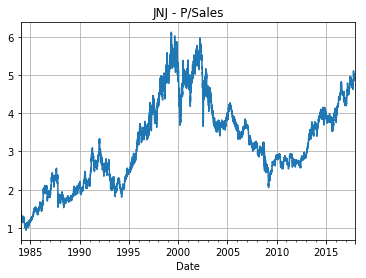

In [27]:
plot_psales(df=df_JNJ, ticker=ticker_JNJ)

Using the reciprocal formula for 10-year returns we get this forecasted return:

$$
Annualized\ Return \simeq 82.0\% / (P/Sales) - 10.9\%
\simeq 82.0\% / 4.9 - 10.9\% \simeq 5.8\%
$$

So according to this formula, the annualized return of the JNJ stock will be around 5.8% over the next 10 years, when dividends are reinvested and ignoring taxes.

Now let us try and plot the P/Book versus the annualized return. We see that it does not fit very well, even for 10-year investment periods where there seems to be two distinct trends in the data. It would require deeper investigation of the company's financial statements to uncover the reason for this.

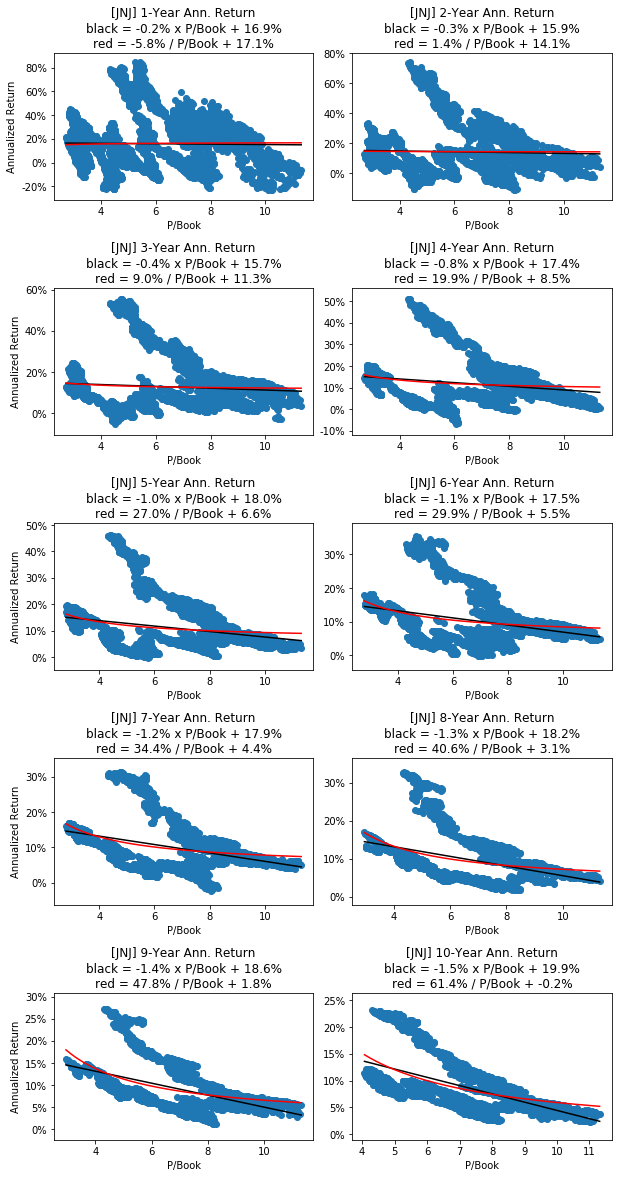

In [28]:
plot_ann_returns(ticker=ticker_JNJ, df=df_JNJ, key=PBOOK)

## Case Study: Procter & Gamble (PG)

Another very large company is Procter & Gamble with the ticker symbol PG, which sells a wide range of consumer products and has almost 100.000 employees.

If we plot the P/Sales ratio versus the annualized return we get rather good fits already for 3-year investment periods.

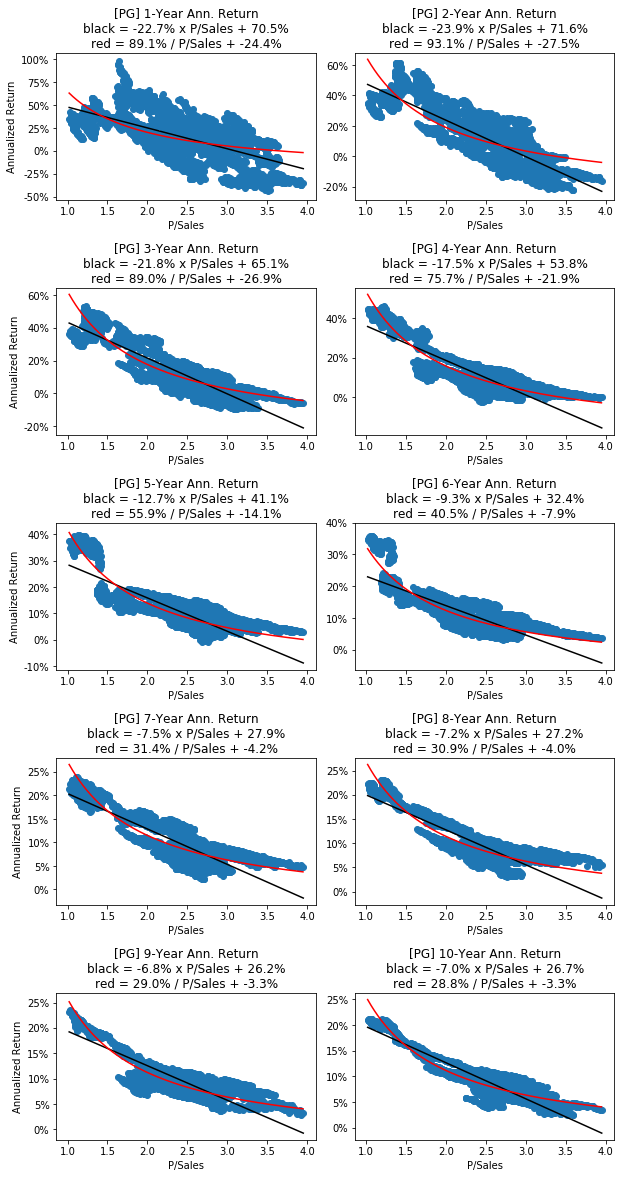

In [29]:
plot_ann_returns(ticker=ticker_PG, df=df_PG, key=PSALES)

When we plot the historical P/Sales ratio, we see that at the end of 2017 it was around 3.5 which was near its all-time high experienced during the bubble around year 2000.

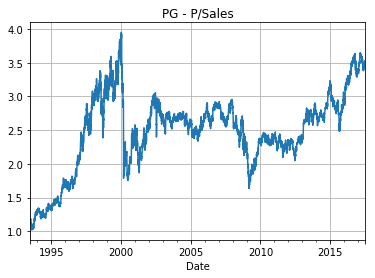

In [30]:
plot_psales(df=df_PG, ticker=ticker_PG)

Using the fitted reciprocal curve for 10-year returns from above, we get a forecasted return of about 4.9% per year, when dividends are reinvested without taxes:

$$
Annualized\ Return \simeq 28.8\% / (P/Sales) - 3.3\% \simeq 
28.8\% / 3.5 - 3.3\% \simeq 4.9\%
$$

## Case Study: Kellogg's (K)

The next company is Kellogg's which trades under the ticker symbol K. The company has about 33.000 employees and is especially known for making breakfast cereals.

When we plot the P/Sales ratio versus the annualized return there is clearly a trend, although the fit is not quite as good as for the other companies we studied above.

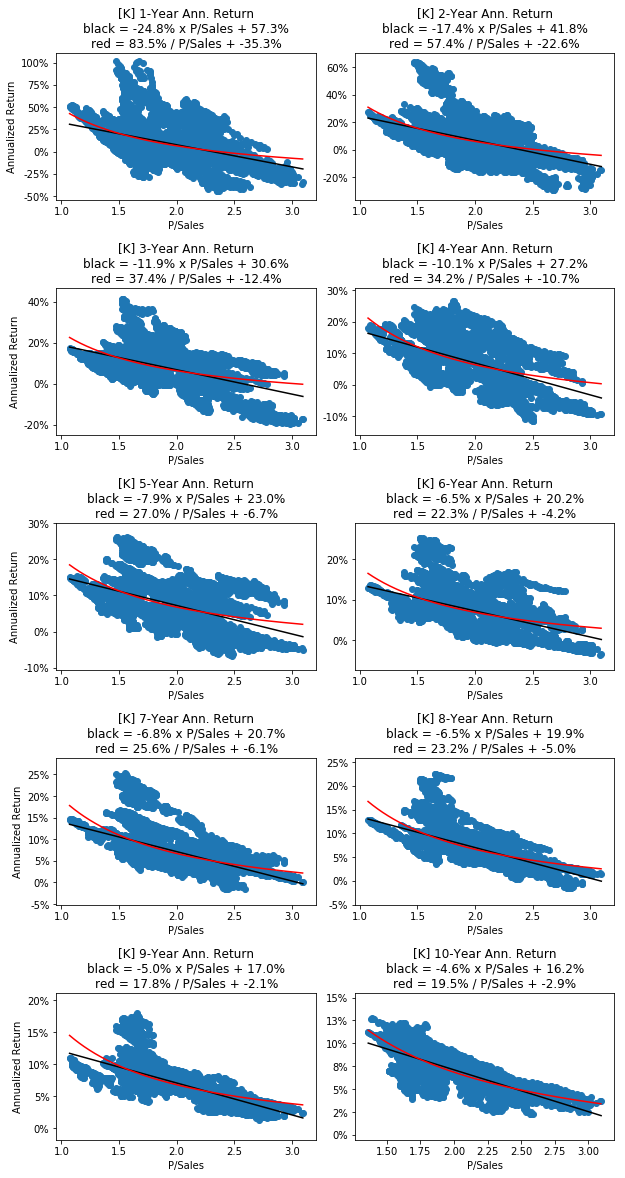

In [31]:
plot_ann_returns(ticker=ticker_K, df=df_K, key=PSALES)

Towards the end of 2017 the P/Sales ratio was about 1.8 which was actually very close to the historical average.

In [32]:
df_K[PSALES].dropna().mean()

1.8626938835082543

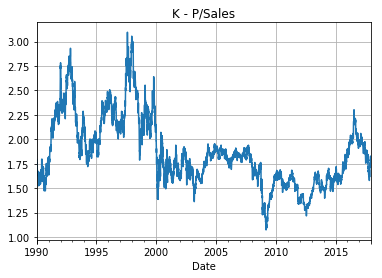

In [33]:
plot_psales(df=df_K, ticker=ticker_K)

Using the fitted reciprocal curve for 10-year returns with the P/Sales ratio of 1.8 we get the forecasted return:

$$
Annualized\ Return \simeq 19.5\% / (P/Sales) - 2.9\% \simeq 
19.5\% / 1.8 - 2.9\% \simeq 7.9\%
$$

So a forecasted return of about 7.9% per year over the next 10 years when dividends are reinvested without taxes. That is about 2% (percentage points) higher than the return forecasted for JNJ and 3% higher than forecasted for PG above. However, there is considerable uncertainty of all these forecasted returns.

Note: In the video lecture I said that the scatter-plots for the K stock show a larger variance around the curve-fits than the other stocks. This may be incorrect because the range of the scatter-plot's y-axis is actually much narrower than for the other stocks. This shows the importance of using proper statistics to measure the goodness of fit, instead of just looking at the scatter-plot. This is also suggested in the research ideas towards the bottom.

## Case Study: Wal-Mart (WMT)

Now let us consider the company Wal-Mart which trades under the ticker symbol WMT. It is an extremely large retail-company with about 2.3 million employees.

If we plot the P/Sales ratio versus the annualized return, we see that the curves fit very poorly for shorter investment periods. For longer investment periods there seems to be at least two separate trends in the data, which we cannot fit with a single line.

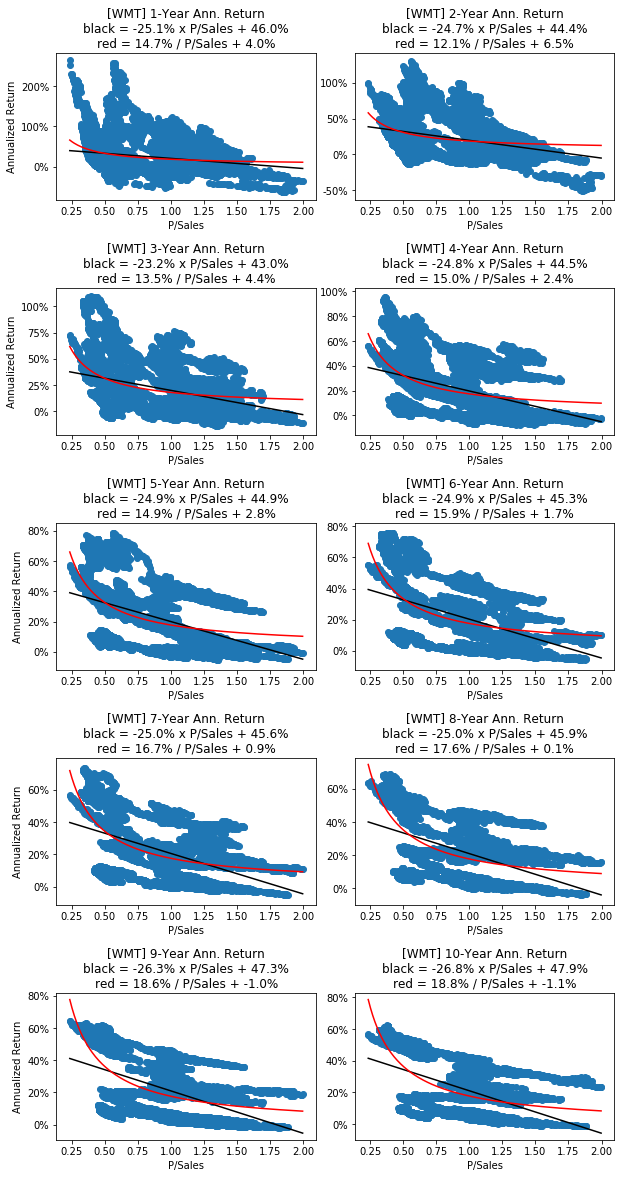

In [34]:
plot_ann_returns(ticker=ticker_WMT, df=df_WMT, key=PSALES)

If we instead try and plot for the P/Book ratio, we get similarly looking plots with poorly fitting curves.

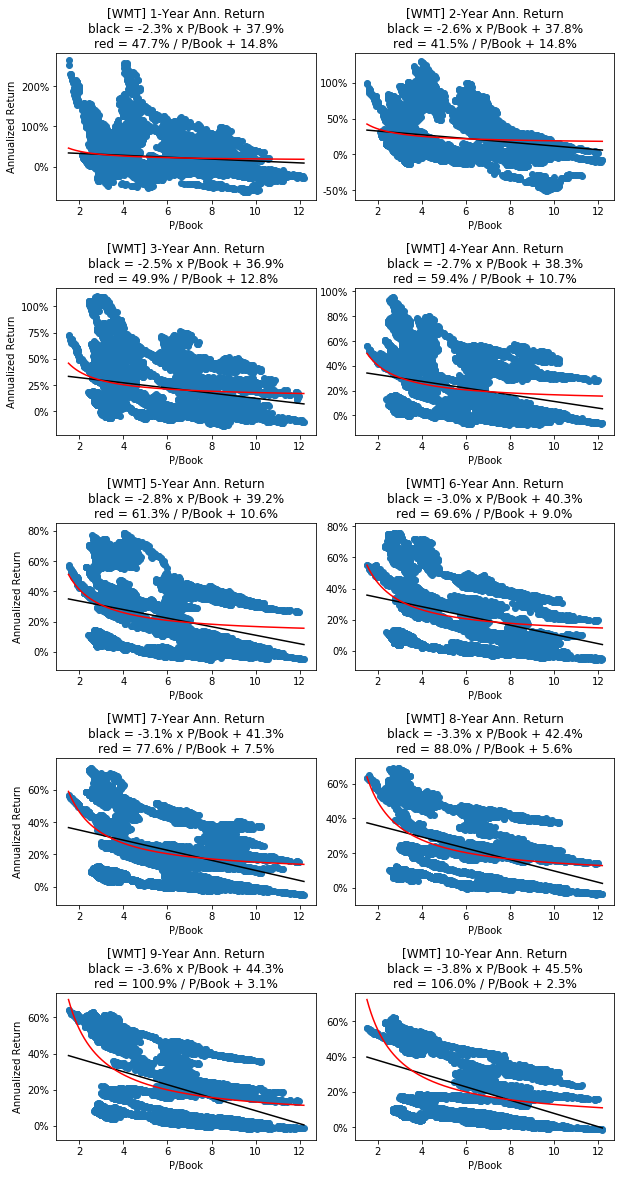

In [35]:
plot_ann_returns(ticker=ticker_WMT, df=df_WMT, key=PBOOK)

If we plot the Sales Per Share and Book-Value Per Share we see highly stable growth. So it is interesting that we cannot fit return-curves to such a stable company. It would require deeper investigation of the company's history and financial statements to try and find the reason for this.

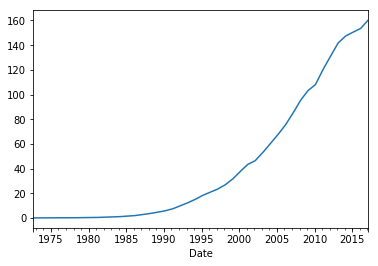

In [36]:
df_WMT[SALES_PER_SHARE].dropna().plot()

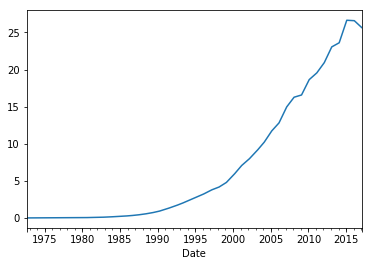

In [37]:
df_WMT[BOOK_VALUE_PER_SHARE].dropna().plot()

## Theoretical Explanation

We have found a strong predictive relationship between the P/Sales or P/Book ratios and the long-term return of the S&P 500 and some individual stocks. Let us now discuss what may be the cause of this relationship and whether it can be expected to continue in the future, so the formulas above can be used to forecast the future returns of the S&P 500 and those individual stocks.

### Random Walk?

For several decades, most finance professors have believed that stock-prices fluctuate completely randomly and cannot be predicted by any means. This may be partially true in the short-term, but it is not true in the long-term because it completely ignores the fact that shares represent part ownership in the underlying businesses, which have real assets, real sales, and real profits that do not fluctuate completely randomly.

The world's all-time best long-term investor is Warren Buffett who learnt investment finance from a man named Ben Graham who used to say that in the short-term the stock-market is a voting machine, but in the long-term the stock-market is a weighing machine. By this he meant that the stock-market does seem to fluctuate randomly in the short-term, but in the long-term the economics of the underlying businesses will dominate the returns of stocks.

When we consider the S&P 500 stock-market index it is really a gauge of all U.S. businesses because the index covers about 80% of the publicly traded companies in terms of size. So we would expect the return of the S&P 500 to roughly follow the growth in the U.S. economy over longer periods of time. But the stock-prices do fluctuate randomly every day, so how does that affect the long-term returns?

### Intrinsic Value

We can better understand this if we consider the **intrinsic value** (or true underlying value) of a stock to be different from the current share-price. For example, if the underlying business of a stock grows 9% per year for 10 years, then the intrinsic value after 10 years has become:

$$
Intrinsic\ Value_{10\ Years} = Intrinsic\ Value_{Today} \cdot 1.09 ^ {10}
$$

If we could buy and sell a company's stock for a price equal to the intrinsic value - and we ignore dividends for now - then the investor's return would simply be 9% compounded for 10 years:

$$
Return = \frac{Intrinsic\ Value_{10\ Years}}{Intrinsic\ Value_{Today}} = 1.09 ^ {10}
$$

But the problem is that nobody knows what the intrinsic value of a business is, because it depends on future earnings which are impossible to know in advance. So there is a lot of guessing when the stock-market tries to establish a fair price for a stock.

Furthermore, because stocks can be bought and sold almost instantly, many market participants are not long-term investors but short-term speculators. This means the share-price may fluctuate significantly during a day even though the intrinsic value of the underlying business has not changed at all.

### Intrinsic Value vs. Share-Price

Instead of considering the share-price to be completely random, we should instead consider it to be a random variable that fluctuates **around** the intrinsic value of the underlying business. We can write it like this for some random number drawn from an unknown distribution:

$$
Share\ Price = Intrinsic\ Value \cdot Random
$$

We might call this random number for the **mispricing factor**, as it causes the shares to be mispriced for all random values except 1.

Now the return we get on the investment is affected by the growth in the intrinsic value as well as the two random variables for the buying and selling prices of the stock:

$$
Return_{10\ Years} = \frac{Share\ Price_{10\ Years}}{Share\ Price_{Today}} = \frac{Intrinsic\ Value_{10\ Years} \cdot Random_{10\ Years}}{Intrinsic\ Value_{Today} \cdot Random_{Today}}
$$

If we still assume the intrinsic value grows 9% per year then we get:

$$
Return_{10\ Years} = 1.09 ^ {10} \cdot \frac{Random_{10\ Years}}{Random_{Today}}
$$

### Total Return vs. Share-Price

In the formulas above we ignored dividends that would be paid out during the investment period of 10 years and reinvested immediately into the same stock. We assume there are no taxes when reinvesting dividends and we call the result for the Total Return of the stock.

We may consider the Total Return by including a share-count in the formula:

$$
Return_{10\ Years} = \frac{Shares_{10\ Years} \cdot Share\ Price_{10\ Years}}{Shares_{Today} \cdot Share\ Price_{Today}} \\
= \frac{Shares_{10\ Years} \cdot Intrinsic\ Value_{10\ Years} \cdot Random_{10\ Years}}{Shares_{Today} \cdot Intrinsic\ Value_{Today} \cdot Random_{Today}}
$$

where the number of shares starts at 1 and increases slightly whenever a dividend is paid out and reinvested into the same stock, according to this formula:

$$
Shares_t = Shares_{t-1} \cdot (1 + \frac{Dividend_t}{Share\ Price_t})
$$

Notice that when calculating the return, the growth in share-count could simply be replaced by an increased growth in the intrinsic value and the result would be identical. In the examples and simulations further below, we will therefore combine these into a single growth-rate to keep the notation simple.

### Annualized Return

We can then calculate the annualized return for investment periods of $N$ years as follows:

$$
Annualized\ Return = (\frac{Shares_{N\ Years} \cdot Share\ Price_{N\ Years}}{Shares_{Today} \cdot Share\ Price_{Today}}) ^ {1/N} - 1 \\
= (\frac{Shares_{N\ Years}}{Shares_{Today}}) ^ {1/N} \cdot (\frac{Intrinsic\ Value_{N\ Years}}{Intrinsic\ Value_{Today}}) ^ {1/N} \cdot (\frac{Random_{N\ Years}}{Random_{Today}}) ^ {1/N} - 1
$$

This makes it clear that the annualized return depends on three things: The annualized return in the intrinsic value, the annualized return in the number of shares from reinvestment of dividends, and the annualized return from the mispricing of the stock at the time of buying and selling.

The random mispricing factors are assumed to be limited e.g. between 0.5 and 2.0 so that the share-price fluctuates **around** the intrinsic value per-share. This means the annualized return on the mispricing factor goes towards 1.0 as the number of years $N$ increases, so in the long-term the annualized return on the stock is dominated by the growth in the intrinsic value and the share-count from reinvestment of dividends:

$$
\lim_{N \rightarrow \infty} Annualized\ Return = (\frac{Shares_{N\ Years}}{Shares_{Today}}) ^ {1/N} \cdot (\frac{Intrinsic\ Value_{N\ Years}}{Intrinsic\ Value_{Today}}) ^ {1/N} - 1
$$

### Examples

Let us consider a few examples of random factors for the buying and selling prices.

First consider the case where the stock is priced exactly at the intrinsic value when it is sold so that $Random_{10\ Years} = 1$, but there is a 20% under-pricing at the time of purchase so that $Random_{Today} = 0.8$. We assume the intrinsic value and share-count from reinvestment of dividends grows at a combined 9% every year. Using the formula above, the annualized return on the stock is then:

$$
Annualized\ Return = 
(\frac{Shares_{N\ Years} \cdot Intrinsic\ Value_{N\ Years}}{Shares_{Today} \cdot Intrinsic\ Value_{Today}}) ^ {1/N} \cdot (\frac{Random_{10\ Years}}{Random_{Today}}) ^ {1/10} - 1 \\
= 1.09 \cdot (\frac{1}{0.8}) ^ {1/10} - 1 \simeq 11.5\% \\
$$

Now consider the opposite case where $Random_{10\ Years} = 1$ but there is now a 20% over-pricing at the time of purchase so that $Random_{Today} = 1.2$. We get:

$$
Annualized\ Return = 1.09 \cdot (\frac{Random_{10\ Years}}{Random_{Today}}) ^ {1/10} - 1 \\
= 1.09 \cdot (\frac{1}{1.2}) ^ {1/10} - 1 \simeq 7.0\% \\
$$

Similarly we can assume the buying stock-price is equal to the intrinsic value so $Random_{Today} = 1$ but now the selling price is 20% below the intrinsic value of the stock so $Random_{10\ Years} = 0.8$. We then get the annualized return:

$$
Annualized\ Return = 1.09 \cdot (\frac{Random_{10\ Years}}{Random_{Today}}) ^ {1/10} - 1 \\
= 1.09 \cdot (\frac{0.8}{1}) ^ {1/10} - 1 \simeq 6.6\% \\
$$

Or we can assume that $Random_{Today} = 1$ but the stock is 20% over-priced when sold so that $Random_{10\ Years} = 1.2$. This gives us:

$$
Annualized\ Return = 1.09 \cdot (\frac{Random_{10\ Years}}{Random_{Today}}) ^ {1/10} - 1 \\
= 1.09 \cdot (\frac{1.2}{1}) ^ {1/10} - 1 \simeq 11.0\% \\
$$

So we see that the annualized return also fluctuates randomly around the combined growth-rate for the intrinsic value and share-count, when the share-price fluctuates randomly around the intrinsic value.

You can try this formula with different choices of intrinsic growth-rate, investment years and random numbers for the buying and selling prices.

### Simulations

We can also simulate thousands of annualized returns with different random factors for the buying and selling share-prices. We first make a little function for doing this simulation and another function for plotting the results.

Note that we draw the random numbers from a uniform distribution here. You can try with another distribution, but the important thing to note is what happens to the spread of the annualized returns in the following plots.

In [38]:
def simulate_ann_returns(intrinsic_growth=0.09,
                         years=10,
                         random_low=0.5,
                         random_high=2.0,
                         n=10000):
    """
    Simulate an investment for the given number of years
    in a stock whose intrinsic value grows at the given rate.
    The buying and selling prices are taken as the intrinsic
    value multiplied by random numbers between the given low
    and high bounds.
    
    NOTE: The growth-rate for the share-count from reinvestment of
    dividends is included in the growth-rate for the intrinsic
    value, so as to keep the notation simple.
    
    :param intrinsic_growth: Annual growth for the intrinsic value.
    :param years: Number of investment years.
    :param random_low: Lower bound for random share-price factors.
    :param random_high: Upper bound for random share-price factors.
    :param n: Number of random samples for the buying and selling prices.
    :return: 3 Numpy arrays (ann_returns, random_buy, random_sell)
    """

    # Helper-function for drawing random uniform numbers.
    def _rnd(n, low, high):
        return np.random.rand(n) * (high - low) + low

    # Uniform random numbers for buying and selling prices.
    random_buy = _rnd(n=n, low=random_low, high=random_high)
    random_sell = _rnd(n=n, low=random_low, high=random_high)
    
    # Calculate the annualized returns for all random
    # buying and selling prices using the formula above.
    ann_returns = (1 + intrinsic_growth) * (random_sell / random_buy) ** (1 / years) - 1

    return ann_returns, random_buy, random_sell

In [39]:
def plot_simulate_ann_returns_hist(*args, **kwargs):
    """
    Simulate and plot a histogram of annualized returns.
    
    Takes the same parameters as simulate_ann_returns().
    """
    
    # Simulate the annualized returns.
    ann_returns, _, _ = simulate_ann_returns(*args, **kwargs)
    
    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Plot histogram.
    ax.hist(ann_returns, bins=100)
    
    # Plot average ann. return as vertical line.
    ax.axvline(np.mean(ann_returns), color='black')

    # Set label.
    label = "Annualized Returns - Mean: {0:.2%}, Std: {1:.2%}".format(np.mean(ann_returns), np.std(ann_returns))
    ax.set_xlabel(label)

    # Convert x-ticks to percentages.
    # We use a custom FuncFormatter because PercentFormatter
    # is inconsistent with string-formatters used elsewhere.
    formatter = FuncFormatter(lambda x, _: '{:.1%}'.format(x))
    ax.xaxis.set_major_formatter(formatter)
    
    # Show the plot.
    plt.show()

First we will try this simulation for 10000 random buying and selling price-factors between 0.5 and 2.0. We use the same growth-rate of 9% per year for the intrinsic value and a 10-year investment period. The result is an average annualized return of about 9.2% with a standard deviation of almost 6% (these numbers will change slightly each time you run the simulation).

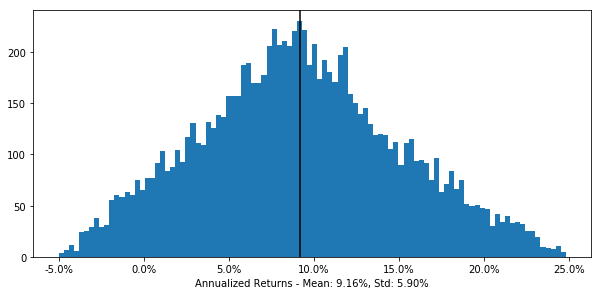

In [40]:
plot_simulate_ann_returns_hist(intrinsic_growth=0.09,
                               years=10,
                               random_low=0.5,
                               random_high=2.0,
                               n=10000)

Now let us try with 20-year investment periods instead. The mean annualized return is now closer to the 9% growth-rate for the intrinsic value and the standard deviation is below 3%.

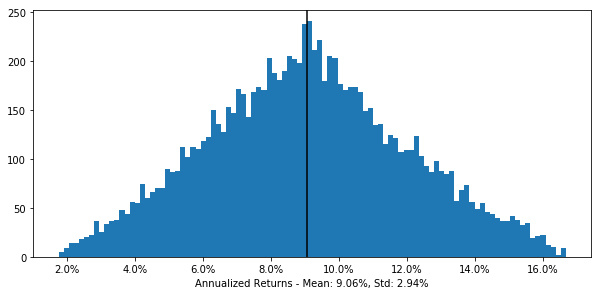

In [41]:
plot_simulate_ann_returns_hist(intrinsic_growth=0.09,
                               years=20,
                               random_low=0.5,
                               random_high=2.0,
                               n=10000)

Let us now try the simulations for 100-year investment periods where the mean annualized return is now almost exactly 9% which was the chosen growth-rate for the intrinsic value, while the standard deviation has become very low at about 0.6%.

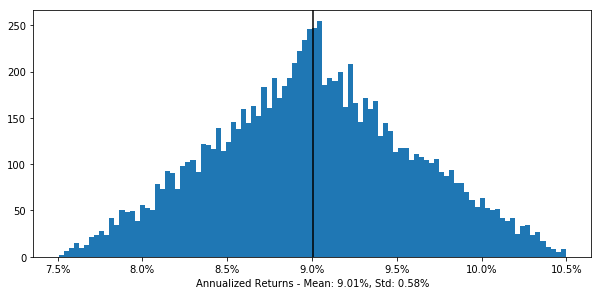

In [42]:
plot_simulate_ann_returns_hist(intrinsic_growth=0.09,
                               years=100,
                               random_low=0.5,
                               random_high=2.0,
                               n=10000)

What we can see from the previous plots is that the annualized returns get closer to the growth-rate for the intrinsic value when the investment periods get longer. So the return is dominated by the growth in intrinsic value for longer investment periods.

Now let us do some simulations for shorter investment periods. First we consider investment periods of 5 years. We see that the mean annualized return has risen slightly to about 9.5% but the standard deviation has doubled to about 12% from the simulations with 10-year investment periods.

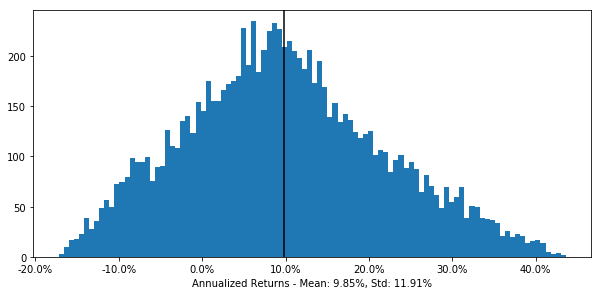

In [43]:
plot_simulate_ann_returns_hist(intrinsic_growth=0.09,
                               years=5,
                               random_low=0.5,
                               random_high=2.0,
                               n=10000)

Now let us try investment periods of only 1 year. This looks almost like a shifted log-normal distribution. This is because the intrinsic growth is only 0.09 but the buying and selling prices are random variables between 0.5 and 2.0, so the return is almost completely dominated by the random share-prices when buying and selling the stock.

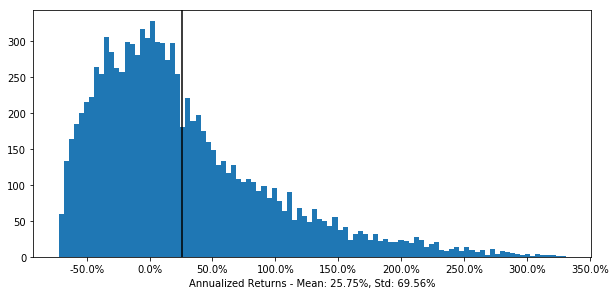

In [44]:
plot_simulate_ann_returns_hist(intrinsic_growth=0.09,
                               years=1,
                               random_low=0.5,
                               random_high=2.0,
                               n=10000)

What we have demonstrated here is that when the share-price fluctuates randomly **around** the intrinsic value of a stock which grows steadily, then the annualized return of the stock will be dominated by these random factors in the short-term, but in the long-term the return of the stock will be dominated by its growth in intrinsic value.

### Simulated Return Curves

We can also make a scatter-plot of the simulations, where the x-axis is the random factor on the buying share-price and the y-axis is the annualized return for e.g. 10 years. This plot will show us if there is a relationship between the buying price-level relative to the intrinsic value versus the annualized return we get from investing a given number of years, and whether this relationship can be approximated in a simple formula.

First we need a little helper-function for making the scatter-plot.

In [45]:
def plot_simulate_ann_returns_scatter(years, **kwargs):
    """
    Simulate annualized returns and make a scatter-plot
    of the random buy-price factor on the x-axis versus
    the annualized return on the y-axis.
    
    This produces a plot similar to those using real data
    from the S&P 500 and individual stocks above.

    This takes the same parameters as simulate_ann_returns().
    """

    # Simulate the annualized returns.
    ann_returns, random_buy, _ = \
        simulate_ann_returns(years=years, **kwargs)    

    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Name of the x-axis variable.
    x_name = "random_buy"
    ax.set_xlabel(x_name)
    
    # Scatter-plot with fitted curves.
    plot_scatter_fit(ax=ax, years=years, ticker="SIM",
                     x=random_buy, y=ann_returns,
                     x_name=x_name)
    
    # Show the plot.
    plt.show()

We can now simulate 1000 random values for the buying- and selling-prices, again chosen as a factor between 0.5 and 2.0 around the intrinsic value of the stock, which is assumed to grow 9% per year.

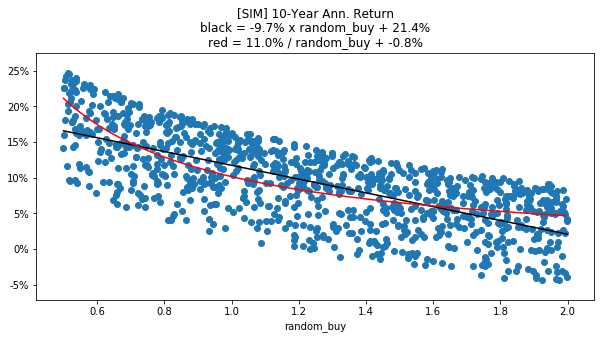

In [46]:
plot_simulate_ann_returns_scatter(intrinsic_growth=0.09,
                                  years=10,
                                  random_low=0.5,
                                  random_high=2.0,
                                  n=1000)

This plot looks remarkably similar to the scatter-plots we showed above using real data from the S&P 500 and for some individual stocks - except of course that the blue dots are spread much more regularly in this plot because they are drawn uniformly at random.

But the principle is the same as we observed in the real-world data, namely that the annualized return is decreased somewhat predictably when the stock's buy-price is high, and conversely that the annualized return is increased when the stock's buy-price is low.

### Sales-Per-Share as Gauge for Intrinsic Value

In the simulations above we knew what the intrinsic value was: It started at 1.0 and grew at 9% per year. We had then defined the share-price to be the intrinsic value multiplied by a random factor between 0.5 and 2.0. So the buy-price was basically just a random number between 0.5 and 2.0.

In the real world we don't know what the intrinsic value of a stock is. If we knew that, we could tell directly whether the stock was cheap or expensive and whether it should be bought or sold.

The intrinsic value is actually also a random variable, although for the companies we have studied here, it turned out to be much more stable than the stock-price fluctuations would justify. The intrinsic value is especially stable for the S&P 500 because it is highly diversified (more on this below).

So the question is now whether it makes sense to use the Sales Per Share as a gauge for the intrinsic value, so the P/Sales ratio is a gauge for whether the stock is mispriced compared to its intrinsic value. Because then we can use the P/Sales ratio as a predictor variable for the future returns of the company.

Let us first look at a plot for the historical Sales Per Share versus the Total Return of the S&P 500, both normalized to be between 0 and 1 for easy comparison. The plot shows that the Sales Per Share grows much more smoothly than the Total Return.

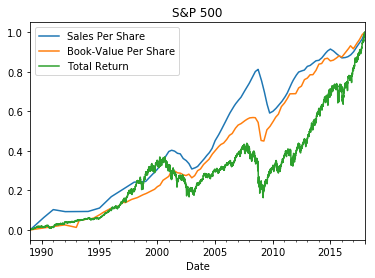

In [47]:
plot_total_return_sales_book_value(df=df_SP500, ticker=ticker_SP500)

Let us try and explain why the Sales Per Share is a useful gauge for the intrinsic value of the S&P 500.

One way of defining the intrinsic value of a company to its long-term shareholders is to use the present value of all future earnings that can be paid out as dividends. The earnings are a fraction of sales and the ratio between earnings and sales is called the Net Profit Margin.

If the future sales grow similarly to their past growth, and if the net profit margin remains roughly the same on average, then we can use the sales-per-share as a gauge for the intrinsic value, because it will be directly related to the future earnings and hence the intrinsic value of the stock, except for a constant factor which is implicitly found through the curve-fitting.

This means that the P/Sales ratio is indeed a gauge for whether the stock is mispriced relative to its intrinsic value - except for some constant factor that will depend on the future sales-growth of the company as well as its net profit margin.

The key question is therefore whether the future sales-growth and net profit margin will be similar to the past. If that is the case, then we can use the curve-fittings from the historical data as a reasonable estimate for future returns of the stock.

### Book-Value Per Share as Gauge for Intrinsic Value

Similarly we can argue that the Book-Value Per Share is a gauge for the intrinsic value of some companies, so the P/Book ratio can be used as a gauge for whether the stock is mispriced, except for some constant factor that is again found through the curve-fitting.

The argument is that a company's intrinsic value depends on its earnings, and the earnings depend on the sales, and the sales depend on the assets, and the assets are related to the equity (or book-value). In other words, the earnings depend on the equity and the ratio between the two is called the Return on Equity (ROE). However, this relationship is strong and predictable for some companies, while it is weak and unpredictable for other companies.

The ROE is also sensitive to changes in capitalization structure, e.g. if the company changes the Debt/Equity ratio of how it has funded its assets. Some companies now operate with negative equity because they need little or no capital to support their operations - an example of this is Moody's (MCO) which has had negative equity for several years now but remains highly profitable.

In general we might expect that that the P/Sales ratio would be a better gauge for mispricing than the P/Book ratio because of these issues.

Interestingly, however, the company Wal-Mart (WMT) has had a high and stable ROE for several decades, yet we could neither use the P/Book or P/Sales to predict its 10-year returns. More research would be required to find the cause of this.

### Predicting the Stock-Market vs. Individual Stocks

We just argued that in order to use the above formulas with the P/Sales ratio as the predictor variable to forecast future returns of a stock, it is required that the future sales-growth and net profit margin of the company must be roughly similar to its past. If the company changes its business radically so the future sales-growth or profit margin is very different from its past, then the P/Sales ratio and the above formulas can no longer be used to forecast the future returns of the stock.

That is why this forecasting method is particularly suited for a broad stock-market index such as the S&P 500, because it is highly diversified and represents a large part of the entire U.S. economy, as opposed to any single company whose business is typically highly concentrated in one field, and is therefore much more sensitive e.g. to changes in technology that could harm the business.

However, if the U.S. economy should experience a great and prolonged contraction, either due to war, natural disaster, or perhaps another financial crisis that cannot be contained, then the above formulas for forecasting the future return will no longer be accurate, because they are based on past data which is no longer representative of the future.

## Conclusion

We have shown that there is a strong empirical relationship between the P/Sales ratio and the long-term returns of the S&P 500 stock-market index as well as some individual stocks. For short-term investment periods of only a few years or less, the P/Sales ratio was found to be a weak predictor for the stock returns.

We have also provided a simulation model along with an explanation for the observed relationship between the P/Sales ratio and future stock returns. The model basically split the share-price into two components: The intrinsic value and a random factor. This caused the share-price to fluctuate randomly around the intrinsic value, which was assumed to have more stable growth. It was then demonstrated using simulations, that the stock return was dominated in the long-term by the growth in the intrinsic value, but it was dominated in the short-term by the random fluctuations in share-price. Furthermore, the simulation model showed that it was possible to estimate the long-term future stock return based on the degree of mispricing at the time the stock was purchased, similar to what we observed for the S&P 500 index and some individual stocks.

In the real world, the mispricing of a stock cannot be measured in absolute terms, but it can be gauged in relative terms e.g. by using the P/Sales ratio, provided the company's future sales-growth and net profit margin is similar to its past. This allows us to fit a curve on a scatter-plot of the historical P/Sales ratio versus the annualized returns e.g. for all 10-year investment periods, and use the fitted formula to forecast the future returns.

However, before using these formulas to forecast the future returns of a stock, you must convince yourself that the future of the company is probably going to be somewhat similar to its past in terms of sales-growth and profit-margin. This is very much a qualitative assessment of the company's future.

If you think the company or perhaps the whole stock-market will experience unprecedented sales-growth or decline in the future, then you can still use the forecasts as base-estimates and then make appropriate adjustments.

For example, at the depths of a market-crash the formula might forecast a 20% annualized return for a 10-year investment in the S&P 500. So you can ask yourself if it seems justified that the U.S. economy has suffered so great damage that the future revenue of U.S. companies will be less than half of what they were just a few years ago. Unless USA has suffered a nuclear attack or a natural disaster on an epic scale, that seems highly unlikely.

Conversely, during stock-market euphoria with very high stock-prices, the formula might predict an annualized loss of -5% for a 10-year investment in the S&P 500. So now you can ask yourself if the U.S. economy is likely going to grow substantially more than it has done in the past, or whether it means that the stock-market is currently overpriced.

## Research Ideas

You are strongly encouraged to do more research on this topic. If you make any new discoveries then please let me know your results. 

To my knowledge, there are no academic studies of predicting the long-term returns of stocks and stock-markets as we have done here. This work has presented the basic idea and methodology, but a lot more research can be done on this subject and it may impact many areas of both theoretical and applied finance.

Here are some ideas you could start researching:

- Use proper statistical methods to measure the strength of the predictive relationship.
- Use other financial ratios as the predictor variable, for example the P/Dividend or P/Earnings ratio (maybe use a rolling 5-year average of earnings). Does it make sense to use those predictor variables? What are the pros and cons of each predictor variable?
- Can you use other economic indicators as predictor variables, such as the unemployment rates, interest rates, currency exchange rates, etc. Does that even make sense? If you find a predictive relationship is it actually causal or is it merely a correlation? How would you test this?
- Can you use industry-specific data as predictor variables for individual companies or sector-indices?
- Use multiple predictor variables together. Does it improve the accuracy of the prediction?
- Find some companies where you have data for at least 20-30 years, but where there is no predictive relationship between P/Sales and 10-year returns. Examine the history of the company and explain why that might be. Maybe the company has fundamentally changed its business and that explains it?
- Find some really old companies where the data for the share-price and P/Sales is available for many decades.
- Try and use other stock-market indices for individual sectors or other countries. You probably need data for at least 20-30 years which may be difficult or impossible to obtain. Perhaps you can build an index yourself?
- How would you use the predictive formulas in portfolio allocation?
- How would you use the predictive formulas for calculating discount rates used in valuation?
- Make simulations with random growth for the intrinsic value. Does it change the results substantially, or do you still observe the same kind of relationship between the `random_buy` variable and the annualized returns?
- Make simulations with different growth-rates in intrinsic value, then fit the return curves and see how well they predict the future returns when the growth is different. Can they still be used as a rough estimate for the future returns, or are they completely inaccurate?
- Make simulations using a small subset of real-world data e.g. for the S&P 500 index and see how well the fitted curves predict actual returns on the full data-period. Can this be used to make predictions for stock-indices where you only have data for a few years? Would this work for individual companies or why not?

## License (MIT)

Copyright (c) 2015-18 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.